In [66]:
# from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla2 import (
#     VanillaTransformer, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla_encoder import (
    VanillaTransformerEncoder, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from finance_utils.electrical2.spot.probabilistic.forecast.power.data.meteo import PFDInterFace, ecmwf_new_energy_args, cma_new_energy_args
from finance_utils.electrical2.spot.probabilistic.forecast.power.data.tr import TRInterFace


from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import ProvinceForecastData
from finance_utils.electrical2.spot.probabilistic.forecast.torch.normalization.basic import MinMax,ZScore,RobustScaler
import numpy
import pickle
import tqdm
from easy_datetime.timestamp import TimeStamp

import torch
from matplotlib import pyplot as plt
# from data_utils.serial_utils.series_trans_utils import MinMax, ZScore, RobustScaler, KmeansCluster

import os

import torch
from torch import nn

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [2]:
root = r"E:\code\github\private\private\db\tencnet\openmeteo\data"

with open(f"{root}\\shanxi_1.pfd", "rb") as f:
    pfd: ProvinceForecastData = pickle.loads(f.read())

100%|██████████| 1133/1133 [00:00<00:00, 1388.99it/s]


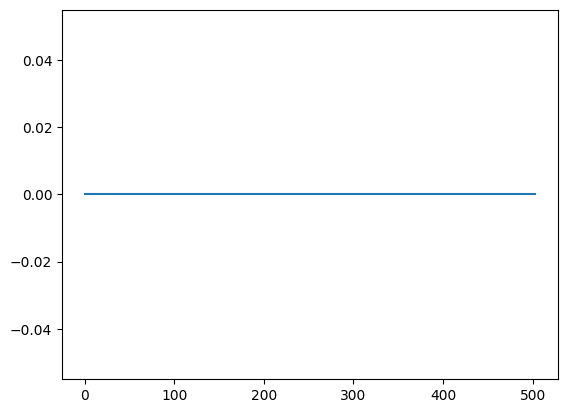

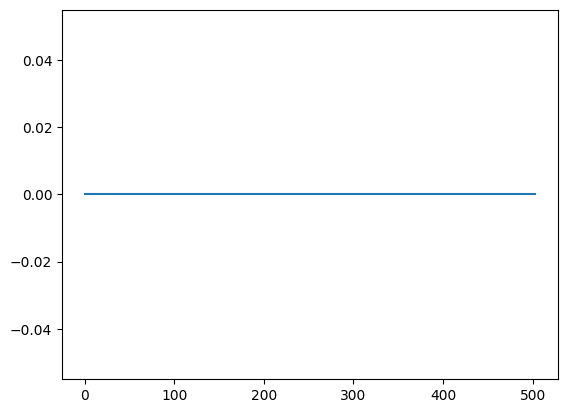

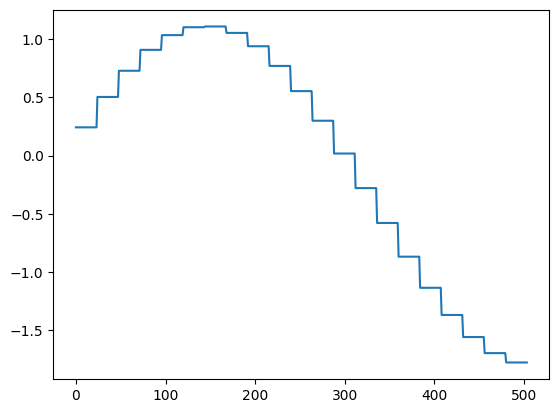

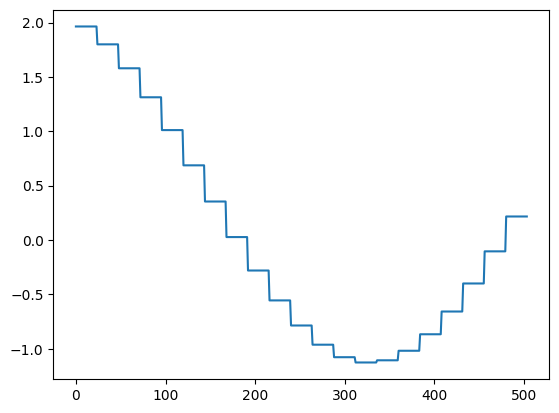

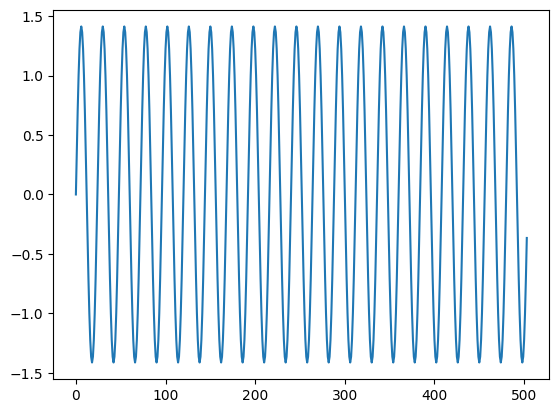

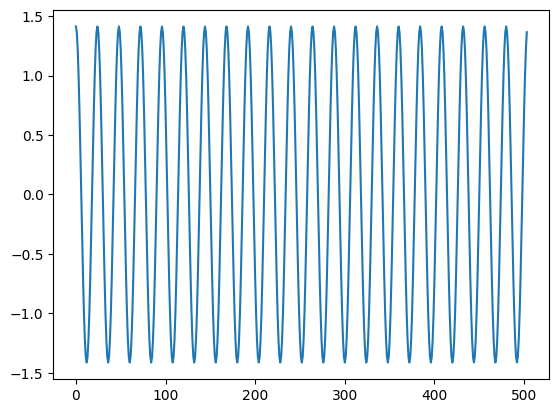

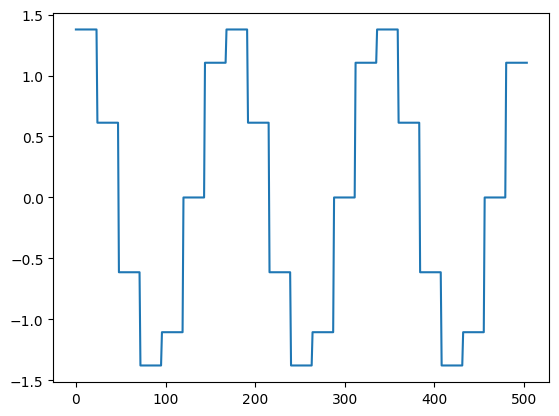

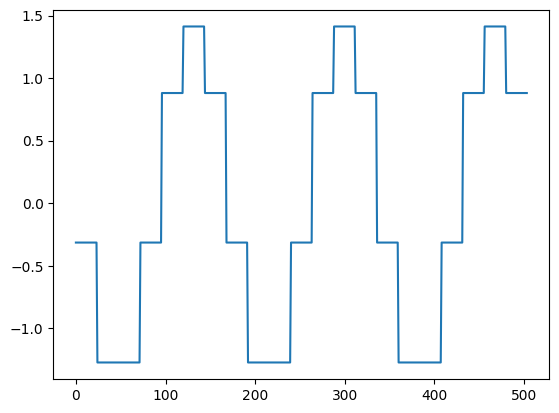

In [137]:
target_day = "2024-10-21"
mf = PFDInterFace.moving_forecast(pfd, target_day, ["cma", "evening"], "2024-10-1")
fore_days = int(TimeStamp("2024-10-21") - TimeStamp("2024-10-1"))
gmf = PFDInterFace.grid_separate(
    PFDInterFace.norm_by_meteo_key(PFDInterFace.time_periodic_encoding(mf), ZScore, cma_new_energy_args, 8),
    cma_new_energy_args,
    8
)

# gmf = [PFDInterFace.norm_by_meteo_key(PFDInterFace.time_periodic_encoding(mf), ZScore, ecmwf_new_energy_args, 8)]


for i in range(8):
    plt.plot(gmf[0][:,i])
    plt.show()

In [138]:
train_act = TRInterFace.hourly_actual_range("shanxi", "2024-10-1", "2024-10-20")
p = ZScore.params(train_act["power"])
y = ZScore.f(train_act["power"])

(480,)

In [67]:
# print(fore_days // 24 //3600)
input_size = gmf[0].shape[1]
d_model = 128
dim_feedforward = 1024
nhead = 4
output_size = 1
# num_layers = 4
num_layers = 8
# batch_size = fore_days * 4
batch_size = fore_days // 24//3600 * 4
# batch_size = 3
lr = 1e-3
use_y_tgt = False

model = VanillaTransformerEncoder(
    input_size=input_size,
    output_size=output_size,
    num_layers=num_layers,
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)

# model = VanillaTransformer(
#     input_size=input_size,
#     output_size=output_size,
#     num_encoder_layers=num_layers,
#     num_decoder_layers=num_layers,
#     d_model=d_model,
#     nhead=nhead,
#     dim_feedforward=dim_feedforward,
#     dropout=0.1
# )

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [85]:
# grid_index = 1
model_list = []
for g in range(len(gmf)):
    grid_index = g
    trained_model = vanilla_transformer_trainer2(
        model, 
        torch.Tensor(gmf[grid_index][:-24]), 
        torch.Tensor(y), 
        batch_size, 
        50, 
        lr=lr, 
        loser=nn.L1Loss, 
        shuffle=True,
        # use_y_tgt=False
    )
    model_list.append(trained_model)

100%|██████████| 50/50 [00:04<00:00, 10.08it/s]


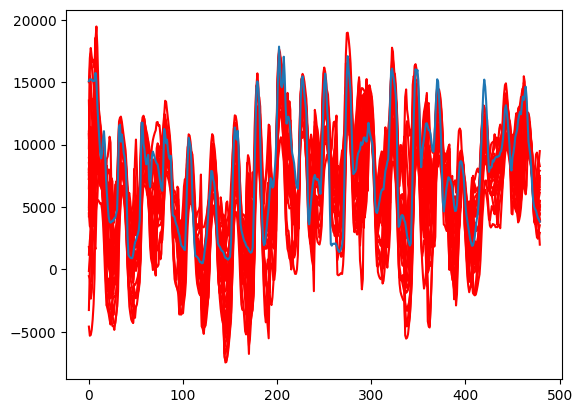

In [105]:
# p_train = vanilla_transformer_tester(trained_model, torch.Tensor(gmf[0][:-24]), batch_size, use_y_tgt=False, train_y_tensor=torch.Tensor(y))
test_act = TRInterFace.hourly_actual_range("shanxi", "2024-10-1", "2024-10-21")
p_train_list = []
for i in range(len(gmf)):
    p_train_list.append(
        vanilla_transformer_tester(model_list[i], torch.Tensor(gmf[i][:-24]), batch_size).cpu().numpy().reshape(-1)
    )
# p_train_matrix = numpy.column_stack((gmf[0][:-24][:,:8], numpy.array(p_train_list).T))





# p_train = vanilla_transformer_tester(trained_model, torch.Tensor(gmf[grid_index][:-24]), batch_size)
# plt.plot(y.reshape(-1), label='Actual')
# plt.plot(p_train.cpu().view(-1), label='Predicted')
# # plt.plot(p[:,1], label='Predicted')
# plt.legend()
# plt.show()
# p_train_matrix

for i in range(len(gmf)):
    plt.plot(ZScore.invert(p_train_list[i], p), color="red")
plt.plot(train_act["power"], label='Actual')
plt.show()

p_train_matrix = numpy.column_stack((gmf[0][:-24][:,:8], numpy.array(p_train_list).T))
    

In [87]:
test_act = TRInterFace.hourly_actual_range("shanxi", "2024-10-1", "2024-10-21")
# p_test = vanilla_transformer_tester(trained_model, torch.Tensor(gmf[0][24:]), batch_size,use_y_tgt=False, train_y_tensor=torch.Tensor(y))
p_test = vanilla_transformer_tester(model_list[0], torch.Tensor(gmf[grid_index][24:]), batch_size)
p_test = ZScore.invert(p_test.cpu().view(-1), p)

svr = SVR()
svr.fit(gmf[0][:-24], y)
z = ZScore.invert(svr.predict(gmf[2][24:]), p)

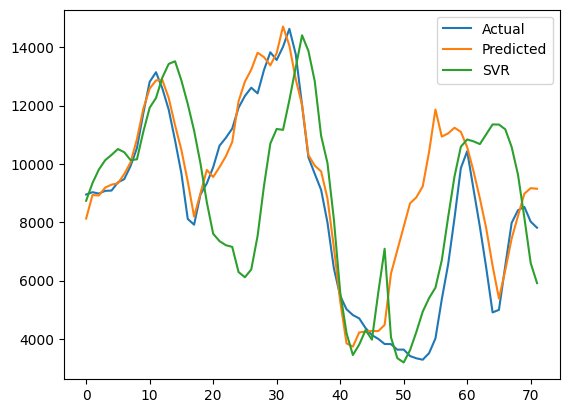

In [88]:
plt.plot(test_act["power"][-24*3:], label='Actual')
plt.plot(p_test[-24*3:], label='Predicted')
plt.plot(z[-24*3:], label='SVR')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

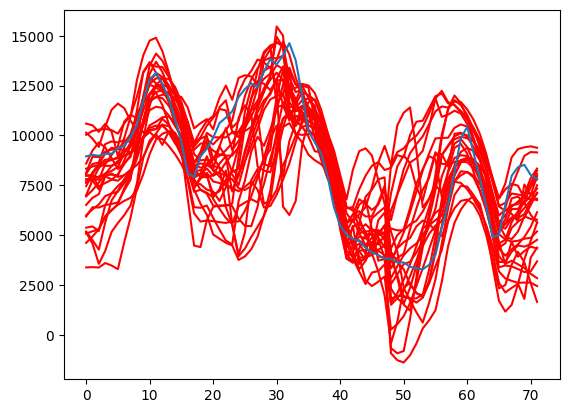

In [91]:
for i in range(len(gmf)):
    p_test = vanilla_transformer_tester(model_list[i], torch.Tensor(gmf[i][24:]), batch_size)
    p_test = ZScore.invert(p_test.cpu().view(-1), p)
    plt.plot(p_test[-24*3:], label=f'{i}', color='red')
plt.plot(test_act["power"][-24*3:], label='Actual')
plt.show()

In [135]:
twice_cooking_model = VanillaTransformerEncoder(
    input_size=p_train_matrix.shape[1],
    output_size=output_size,
    num_layers=num_layers,
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)

twice_cooked_module = vanilla_transformer_trainer2(
    twice_cooking_model, 
    torch.Tensor(p_train_matrix), 
    torch.Tensor(y), 
    batch_size, 
    50, 
    lr=lr, 
    loser=nn.MSELoss, 
    shuffle=True,
    # use_y_tgt=False
)

100%|██████████| 50/50 [00:04<00:00, 10.22it/s]


In [117]:
test_model_list = []
for g in range(len(gmf)):
    grid_index = g
    trained_model = vanilla_transformer_trainer2(
        model, 
        torch.Tensor(gmf[grid_index][:-24]), 
        torch.Tensor(y), 
        batch_size, 
        50, 
        lr=lr, 
        loser=nn.L1Loss, 
        shuffle=True,
        # use_y_tgt=False
    )
    test_model_list.append(trained_model)

100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


In [118]:
p_test_list = []
for i in range(len(gmf)):
    p_test_list.append(
        vanilla_transformer_tester(test_model_list[i], torch.Tensor(gmf[i][24:]), batch_size).cpu().numpy().reshape(-1)
    )
    
p_test_matrix = numpy.column_stack((gmf[0][24:][:,:8], numpy.array(p_test_list).T))

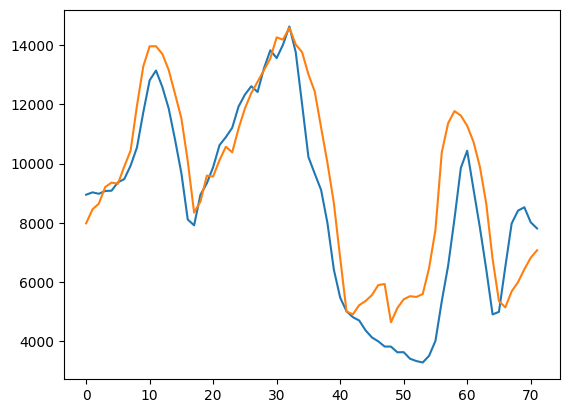

In [136]:
p_test = vanilla_transformer_tester(twice_cooked_module, torch.Tensor(p_test_matrix), batch_size)

p_test = ZScore.invert(p_test.cpu().view(-1), p)

plt.plot(test_act["power"][-24*3:], label='Actual')
plt.plot(p_test[-24*3:], label='Actual')
plt.show()